In [1]:
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2hsv
from skimage.filters import threshold_sauvola
from skimage.segmentation import mark_boundaries
import rasterio
import glob
import matplotlib.pyplot as plt

In [2]:
logger = log.get_logger(__name__)
conf = utils.load_config('base')

13-Nov-23 21:17:06 - INFO - Starting 'load_config'.
13-Nov-23 21:17:06 - INFO - Finished 'load_config' in 0.0145 secs.


In [46]:
def load_cropped_tifs(path):
    return glob.glob(f'{path}*.tif')


def load_raster(image_path):
    with rasterio.open(image_path) as src:
        # Read the data and transpose the dimensions
        raster_data = src.read().transpose(1, 2, 0)
    return raster_data


def normalize_image(image):
    normalized_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    logger.info(f'Normalized image shape: {normalized_image.shape}')
    return normalized_image


def process_images(image_paths):
    
    ms_imgs = []
    norm_ms_imgs = []
    norm_hs_imgs = []

    for image_path in image_paths:
        raster_data = load_raster(image_path)
        logger.info(f'Raster data shape: {raster_data.shape}')

        ms_imgs.append(raster_data)

        norm_ms_img = normalize_image(raster_data)
        norm_ms_imgs.append(norm_ms_img)

        norm_hs_img = normalize_hyperspectral_image(raster_data)
        norm_hs_imgs.append(norm_hs_img)

    return ms_imgs, norm_ms_imgs, norm_hs_imgs


# def get_hyperspectral_images(image_paths):
#     cropped_ms = []
#     for image_path in image_paths:
#         raster_data = load_raster(image_path)
#         logger.info(f'Raster data shape: {raster_data.shape}')
#         cropped_ms.append(raster_data)
#     return cropped_ms


def normalize_hyperspectral_image(image):
    min_val = np.min(image, axis=(0, 1))
    max_val = np.max(image, axis=(0, 1))
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image


def plot_all_rasters(ms_imgs):
    num_images = len(ms_imgs)

    # Set up the plot with 4 columns
    fig, axes = plt.subplots()

    for i in range(num_images):
        rgb_comp = np.dstack((ms_imgs[i][7], ms_imgs[i][4], ms_imgs[i][2]))  # Assuming band_8 is at index 7, band_5 at index 4, and band_3 at index 2

        axes.imshow(rgb_comp)
        axes.set_title('RGB Composite Image')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

def plot_all_bands(image):
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))

    for i in range(2):
        for j in range(5):
            band_number = j * 2 + i
            axs[i, j].imshow(image[:, :, band_number]) # cmap='gray'
            axs[i, j].set_title(f'Band {band_number + 1}')

    plt.tight_layout()
    plt.show()


def plot_rgb_composite(image):
    # Select the R, G, and B bands
    r_band = image[:, :, 7]
    g_band = image[:, :, 4]
    b_band = image[:, :, 2]

    # Stack the R, G, and B bands together
    rgb_img = np.dstack((r_band, g_band, b_band))

    # Plot the RGB composite image
    plt.imshow(rgb_img)
    plt.title('RGB Composite Image')
    plt.show()

In [14]:
cropped_fns_ms = load_cropped_tifs(conf.data.path_pri_ms)
# cropped_ms = get_hyperspectral_images(cropped_fns_ms[:2])
ms_imgs, norm_ms_imgs, norm_hs_imgs = process_images(cropped_fns_ms[:2])

13-Nov-23 21:20:27 - INFO - Raster data shape: (37, 37, 10)
13-Nov-23 21:20:27 - INFO - Normalized image shape: (37, 37, 10)
13-Nov-23 21:20:27 - INFO - Raster data shape: (37, 38, 10)
13-Nov-23 21:20:27 - INFO - Normalized image shape: (37, 38, 10)


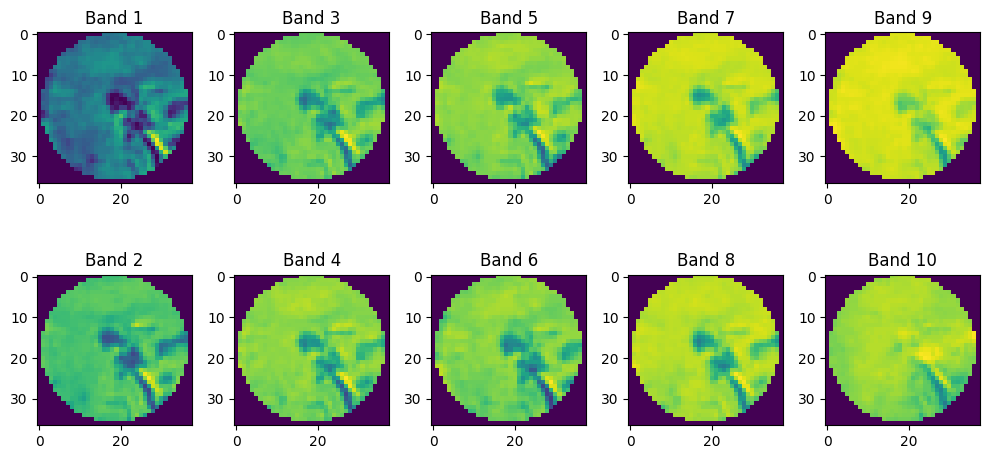

In [48]:
plot_all_bands(norm_hs_imgs[1]) 

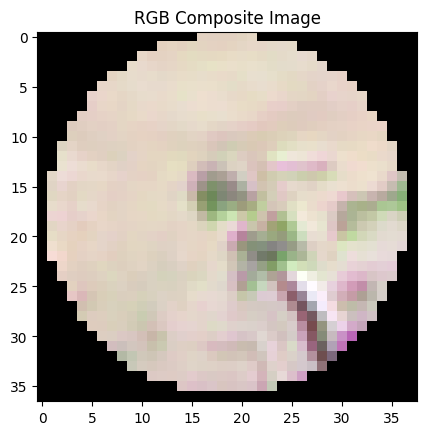

In [49]:
plot_rgb_composite(norm_hs_imgs[1]) 

In [ ]:
plot_rgb_composite(norm_ms_imgs[1]) 

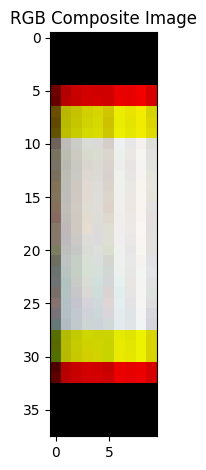

In [17]:
plot_all_rasters(norm_hs_imgs)

In [ ]:
# Plan:

## Create a mask based on segmentation
###  Mask all rasters
### Layer all the rasters to create a composite image

## Extract features from each of these rasters / composite image

## Use features to train classifier